In [145]:
import pandas as pd
import numpy as np
import copy
import warnings

warnings.filterwarnings("ignore")

In [146]:
np.random.seed(42)

In [147]:
data = pd.read_parquet('../data/sas/mart/data_mart.parquet')

<h3>NA</h3>

In [148]:
data.isna().sum(axis=0).sum()

0

In [149]:
df = copy.deepcopy(data)

In [150]:
df.shape

(45916, 39)

<h3>Remove correlation</h3>

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.context('seaborn');

In [152]:
corr = df.corr(method='spearman')

In [153]:
# flag correlated items as True (except diagonal)
corr_mask = (abs(corr) > 0.85) * np.invert(np.eye(len(corr)).astype(bool))
# remove them
decorr_columns = corr[corr_mask].isna().all()
# get names
decorr_columns = decorr_columns[decorr_columns].index.values

In [154]:
decorr_columns = decorr_columns[(decorr_columns != 'none') * (decorr_columns != 'Unknown')]

In [155]:
df = df[decorr_columns]

In [156]:
corr = df.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,avg_item_profit,related products,office goods,breastfeeding products,"textile, knitwear",footwear,toys,women things,goods for pets,cosmetics and hygiene,diapers,avg_delivered
avg_item_profit,1.00,-0.03,-0.05,-0.15,0.07,0.11,-0.08,-0.02,-0.11,-0.23,-0.32,0.02
related products,-0.03,1.00,0.04,-0.00,0.03,0.01,0.03,0.02,-0.00,0.01,-0.02,-0.02
office goods,-0.05,0.04,1.00,0.00,-0.01,0.02,0.03,0.02,-0.00,0.03,-0.04,-0.02
breastfeeding products,-0.15,-0.00,0.00,1.00,0.02,-0.05,-0.13,0.03,-0.02,0.22,0.06,-0.02
"textile, knitwear",0.07,0.03,-0.01,0.02,1.00,0.05,-0.19,0.04,-0.02,0.01,-0.13,-0.09
footwear,0.11,0.01,0.02,-0.05,0.05,1.00,-0.11,0.04,-0.02,-0.03,-0.10,-0.05
toys,-0.08,0.03,0.03,-0.13,-0.19,-0.11,1.00,-0.01,-0.06,-0.13,-0.28,0.02
women things,-0.02,0.02,0.02,0.03,0.04,0.04,-0.01,1.00,0.02,0.08,0.01,-0.02
goods for pets,-0.11,-0.00,-0.00,-0.02,-0.02,-0.02,-0.06,0.02,1.00,0.01,-0.03,-0.01
cosmetics and hygiene,-0.23,0.01,0.03,0.22,0.01,-0.03,-0.13,0.08,0.01,1.00,0.17,-0.04


In [157]:
df.shape

(45916, 12)

<h3>Remove outliers</h3>

In [158]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

In [159]:
%%time
outliers = IsolationForest(n_estimators=20, random_state=42).fit_predict(df.values)  # fit trees  
outliers = (outliers+1)//2

print('% of outliers with Isolation forest:', 1 - (np.sum(outliers) / df.shape[0]))

% of outliers with Isolation forest: 0.04048697621744057
CPU times: user 119 ms, sys: 23.1 ms, total: 142 ms
Wall time: 141 ms


In [160]:
df = df.loc[np.array(df.index)[outliers == 1]]

In [161]:
df.shape

(44057, 12)

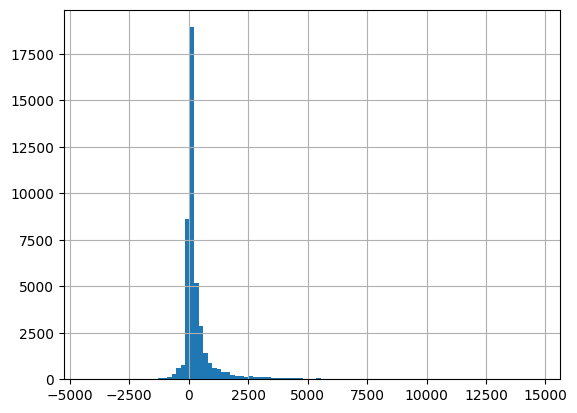

In [162]:
df['avg_item_profit'].hist(bins=100);

In [163]:
sign = (df['avg_item_profit'] > 0).astype(int)*2-1
df['avg_item_profit_log'] = (sign * np.log1p(np.abs(df['avg_item_profit'])))

In [164]:
df = df.drop('avg_item_profit', axis=1)

<h3>Normalize data</h3>

In [165]:
from sklearn import preprocessing

In [166]:
# define scaler
scaler = preprocessing.StandardScaler()
# normalize
X = scaler.fit_transform(df)

<h3>K-means</h3>

In [167]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, MiniBatchKMeans, OPTICS

In [168]:
from scipy.spatial.distance import cdist

In [169]:
%%time
# k means determine k
distortions = []
K_range = range(1,12)
for k in K_range:
    kmeanModel = KMeans(n_clusters=k, max_iter=1500, n_init=40, random_state=42).fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    
    print('{} / {}'.format(k,K_range[-1]))

1 / 11
2 / 11
3 / 11
4 / 11
5 / 11
6 / 11
7 / 11
8 / 11
9 / 11
10 / 11
11 / 11
CPU times: user 1min 17s, sys: 13.3 s, total: 1min 30s
Wall time: 13 s


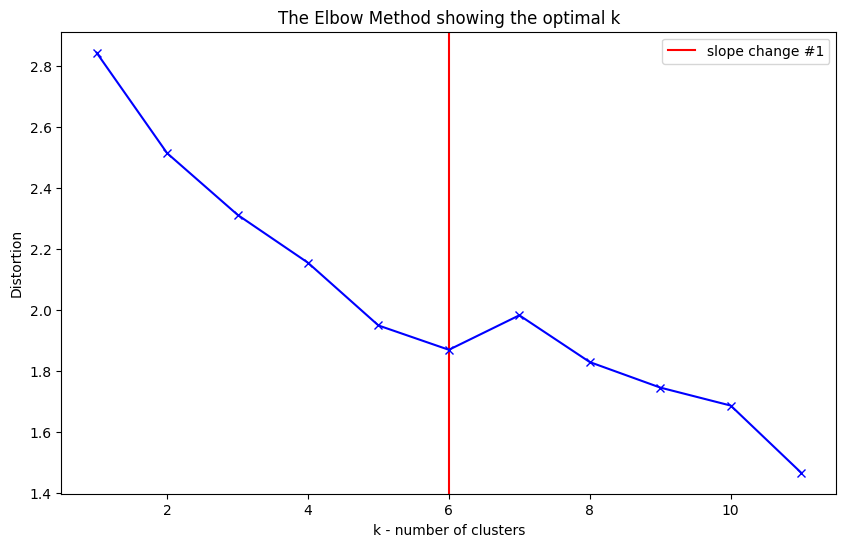

In [172]:
# Plot the elbow
plt.figure(figsize=(10,6))
plt.axvline(6, 0, 1, label='slope change #1', color='red')
#plt.axvline(8, 0, 1, label='slope change #1', color='orange')
plt.plot(K_range, distortions, 'bx-')
plt.xlabel('k - number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.legend(); plt.show()

<h3>Visualize</h3>

In [173]:
from sklearn.decomposition import PCA, TruncatedSVD

In [174]:
Y_pca = PCA(n_components=2).fit_transform(X);
Y_svd = TruncatedSVD(n_components=2).fit_transform(X);

In [181]:
K = 6
kmeanModel = KMeans(n_clusters=K, max_iter=1500, n_init=100, random_state=42).fit(X)

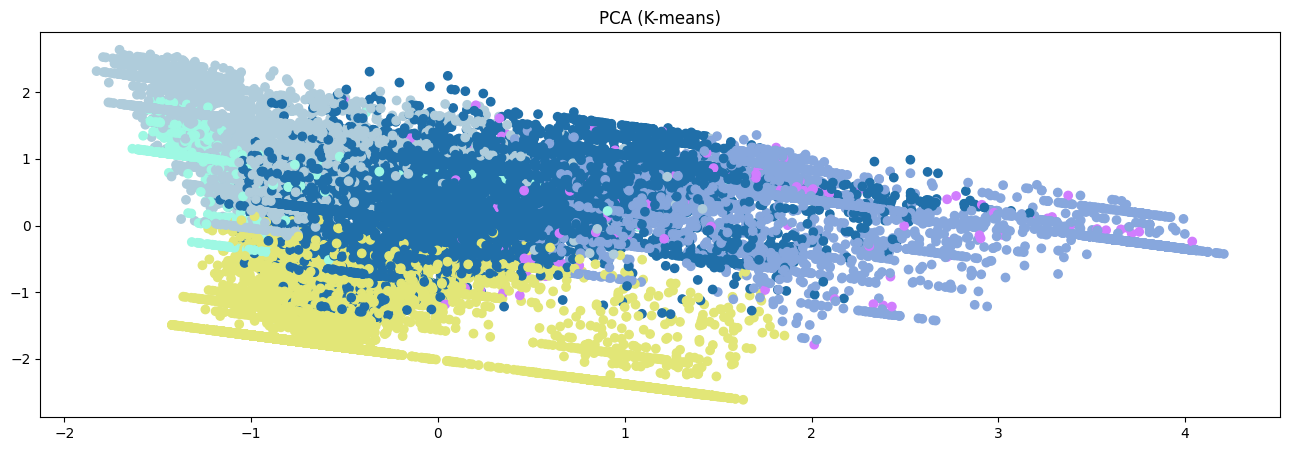

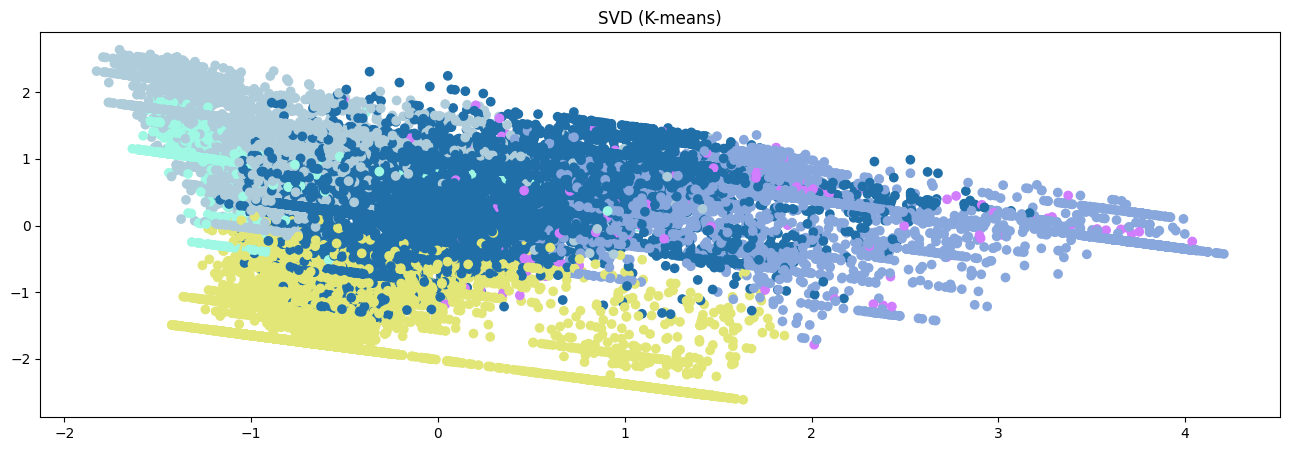

In [182]:
np.random.seed(21)
colors = np.sqrt(np.random.randint(0,255, size=(K, 3))/255)
c_arr = np.array(list(map(lambda x: colors[x], list(kmeanModel.labels_))))

plt.figure(figsize=(16,5)); plt.title('PCA (K-means)')
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=c_arr);

plt.figure(figsize=(16,5)); plt.title('SVD (K-means)')
plt.scatter(Y_svd[:, 0], Y_svd[:, 1], c=c_arr);

In [183]:
labels, counts = np.unique(kmeanModel.labels_, return_counts=True)

In [184]:
cluster_sizes = pd.Series(data=counts, index=labels).sort_index(ascending=True)

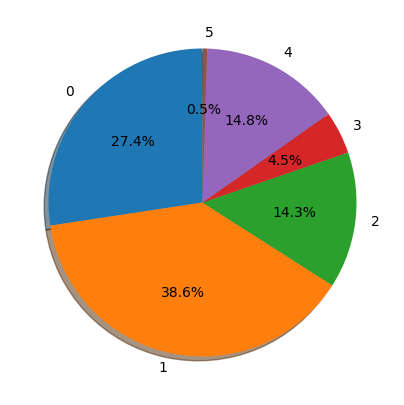

In [185]:
plt.figure(figsize=(16,5))
plt.pie(cluster_sizes, labels=cluster_sizes.index, autopct='%1.1f%%', shadow=True, startangle=90);

In [186]:
summary_stat = copy.deepcopy(df)
summary_stat['cluster'] = kmeanModel.labels_

In [187]:
stats = summary_stat.groupby('cluster').mean()#.T.plot.bar();
stats

,related products,office goods,breastfeeding products,"textile, knitwear",footwear,toys,women things,goods for pets,cosmetics and hygiene,diapers,avg_delivered,avg_item_profit_log
cluster,,,,,,,,,,,,
0,0.001904,0.006146,0.003359,0.009717,0.002976,0.933467,0.000011,0.000190,0.002803,0.013441,0.942794,4.006437
1,0.002794,0.035662,0.144894,0.029786,0.004540,0.044764,0.001907,0.000704,0.149075,0.064698,0.938448,5.023215
2,0.000880,0.002665,0.010268,0.867482,0.012061,0.047205,0.000288,0.000471,0.007529,0.021363,0.899119,5.069768
3,0.000000,0.000419,0.003975,0.046447,0.891981,0.030897,0.000000,0.000051,0.001134,0.010220,0.940068,5.561496
4,0.000153,0.001443,0.009245,0.008471,0.002505,0.022466,0.000000,0.000251,0.019083,0.872106,0.932611,1.739620
5,0.000100,0.012849,0.030052,0.079901,0.011184,0.116520,0.003991,0.464701,0.078487,0.123459,0.924478,2.826021


In [188]:
pd.DataFrame(pd.Series(kmeanModel.labels_, df.index, name='k_means')).to_parquet('../data/sas/mart/kmeans.parquet')

<h3>DBSCAN</h3>

In [189]:
import math

In [192]:
%%time
X_sample = pd.DataFrame(X).sample(frac=1.0, random_state=42).values
eps, cluster_counts = [], []
for i in range(6, 20, 2):
    eps_p = 1.5 + 0.1*i
    dbscan = DBSCAN(eps=eps_p, algorithm='kd_tree', n_jobs=-1).fit(X_sample)
    n_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
    eps.append(eps_p); cluster_counts.append(n_clusters_)
    print('{} / {}'.format(i+1, 10))

7 / 10
9 / 10
11 / 10
13 / 10
15 / 10
17 / 10
19 / 10
CPU times: user 10min 39s, sys: 17.2 s, total: 10min 56s
Wall time: 1min 54s


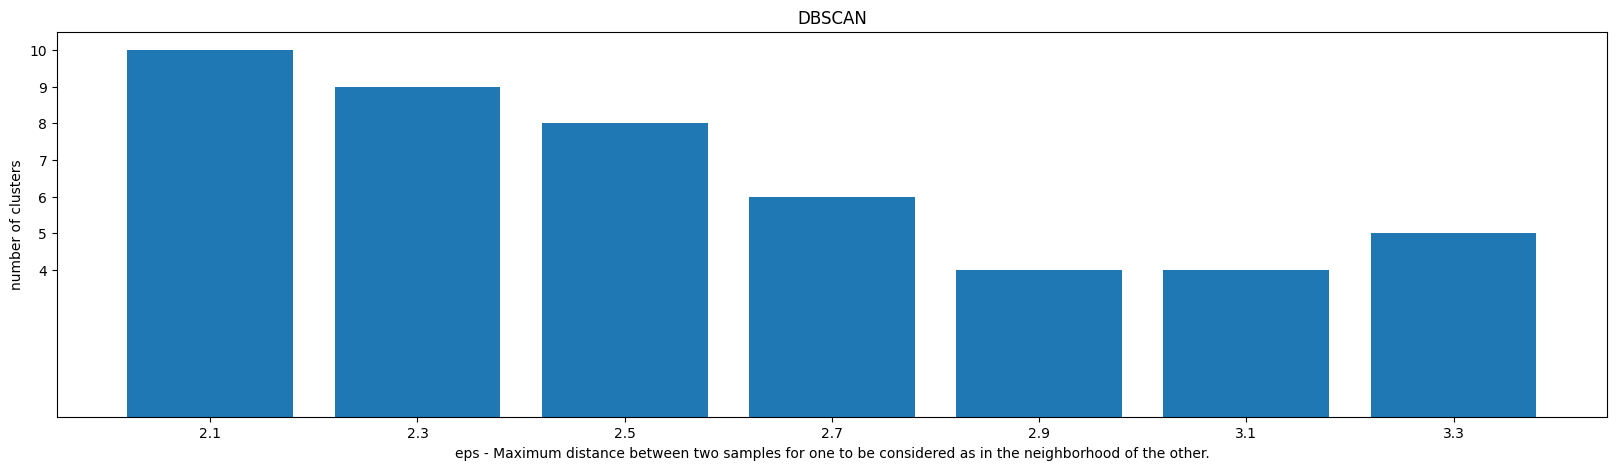

In [193]:
plt.figure(figsize=(20,5));
plt.yticks(range(min(cluster_counts), math.ceil(max(cluster_counts))+1));
plt.bar(np.round(np.array(eps), 2).astype(str), cluster_counts)
plt.xlabel('eps - Maximum distance between two samples for one to be considered as in the neighborhood of the other.')
plt.ylabel('number of clusters')
plt.title('DBSCAN');

<h3>T-SNE</h3>

In [194]:
from sklearn.manifold import TSNE

In [195]:
x_sample = np.random.choice(len(X), size=len(X), replace=False)

In [196]:
%%time
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=600)
tsne_results = tsne.fit_transform(X[x_sample])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 44057 samples in 0.011s...
[t-SNE] Computed neighbors for 44057 samples in 12.664s...
[t-SNE] Computed conditional probabilities for sample 1000 / 44057
[t-SNE] Computed conditional probabilities for sample 2000 / 44057
[t-SNE] Computed conditional probabilities for sample 3000 / 44057
[t-SNE] Computed conditional probabilities for sample 4000 / 44057
[t-SNE] Computed conditional probabilities for sample 5000 / 44057
[t-SNE] Computed conditional probabilities for sample 6000 / 44057
[t-SNE] Computed conditional probabilities for sample 7000 / 44057
[t-SNE] Computed conditional probabilities for sample 8000 / 44057
[t-SNE] Computed conditional probabilities for sample 9000 / 44057
[t-SNE] Computed conditional probabilities for sample 10000 / 44057
[t-SNE] Computed conditional probabilities for sample 11000 / 44057
[t-SNE] Computed conditional probabilities for sample 12000 / 44057
[t-SNE] Computed conditional probabilities for s

In [197]:
sne_labels = kmeanModel.predict(X)[x_sample]

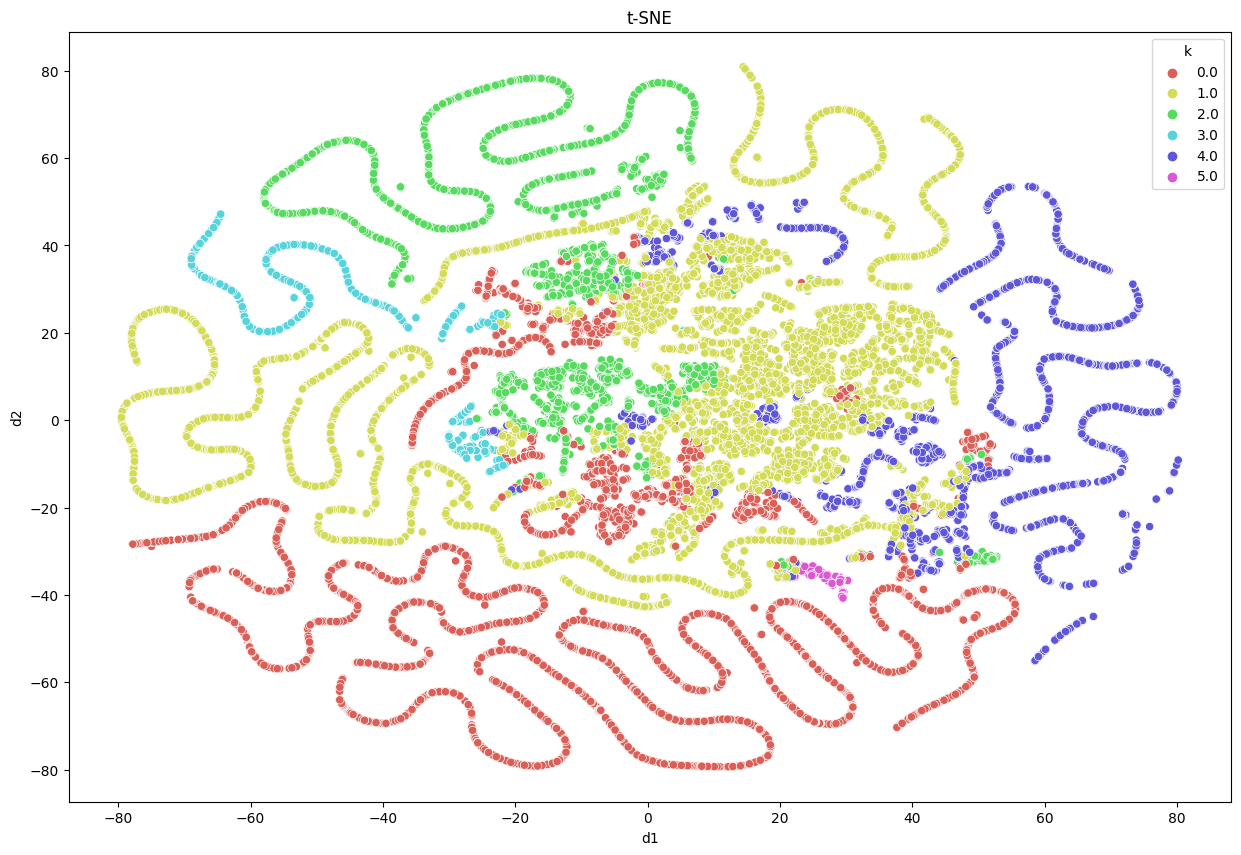

In [199]:
tSNE = pd.DataFrame(np.vstack((tsne_results.T, sne_labels)).T, columns=['d1', 'd2', 'k'])

plt.figure(figsize=(15,10)); plt.title('t-SNE')
sns.scatterplot(x='d1', y='d2', hue='k', data=tSNE, legend='full', alpha=1.,
                palette=sns.color_palette('hls', kmeanModel.n_clusters));

<h3>RFM</h3>

In [200]:
#Recency — number of days since the last purchase
#Frequency — number of transactions made over a given period
#Monetary — amount spent over a given period of time

In [201]:
#ds = pd.read_parquet('./data/clean/all_positions.parquet')
ds = pd.read_csv('../data/sas/all_positions.csv')

In [202]:
ds = ds.rename(columns={'Телефон_new': 'phone'})

In [203]:
ds['ДатаДоставки'] = pd.to_datetime(ds['ДатаДоставки'], format='%Y-%m-%d')

In [204]:
ds = ds.sort_values(by='ДатаДоставки', ascending=False).groupby('phone').head(1)

In [205]:
most_recent = ds['ДатаДоставки'].max()

In [206]:
# Recency
ds['Recency'] = most_recent - ds['ДатаДоставки']

In [207]:
Recency = ds.set_index('phone')['Recency'].dropna()
Recency = Recency[Recency.index.isin(data.index)]
Recency

phone
55574952-54495149535073     0 days
55575449-57535254515373     6 days
55574857-56495152564976    10 days
55575450-50565257574878    10 days
55574952-48524855555674    10 days
                            ...   
55575053-52535554564978   104 days
55574852-49485452495570   104 days
55575455-48545456485675   104 days
55575054-51495751515071   104 days
55575450-57505048555771   105 days
Name: Recency, Length: 45916, dtype: timedelta64[ns]

In [208]:
recency = pd.DataFrame(Recency.dt.days)
frequency = data[['successful_orders_count']].rename(columns={'successful_orders_count': 'Frequency'})
monetary = data[['total_profit']].rename(columns={'total_profit': 'Monetary'})

In [209]:
assert recency.shape == frequency.shape == monetary.shape

In [210]:
RFM = pd.merge(pd.merge(recency, frequency, on='phone'), monetary, on='phone')

In [211]:
RFM

,Recency,Frequency,Monetary
phone,,,
55574952-54495149535073,0,1,-454.75
55575449-57535254515373,6,1,524.24
55574857-56495152564976,10,5,5281.98
55575450-50565257574878,10,1,108.35
55574952-48524855555674,10,5,8713.21
...,...,...,...
55575053-52535554564978,104,1,223.11
55574852-49485452495570,104,1,135.25
55575455-48545456485675,104,1,800.00


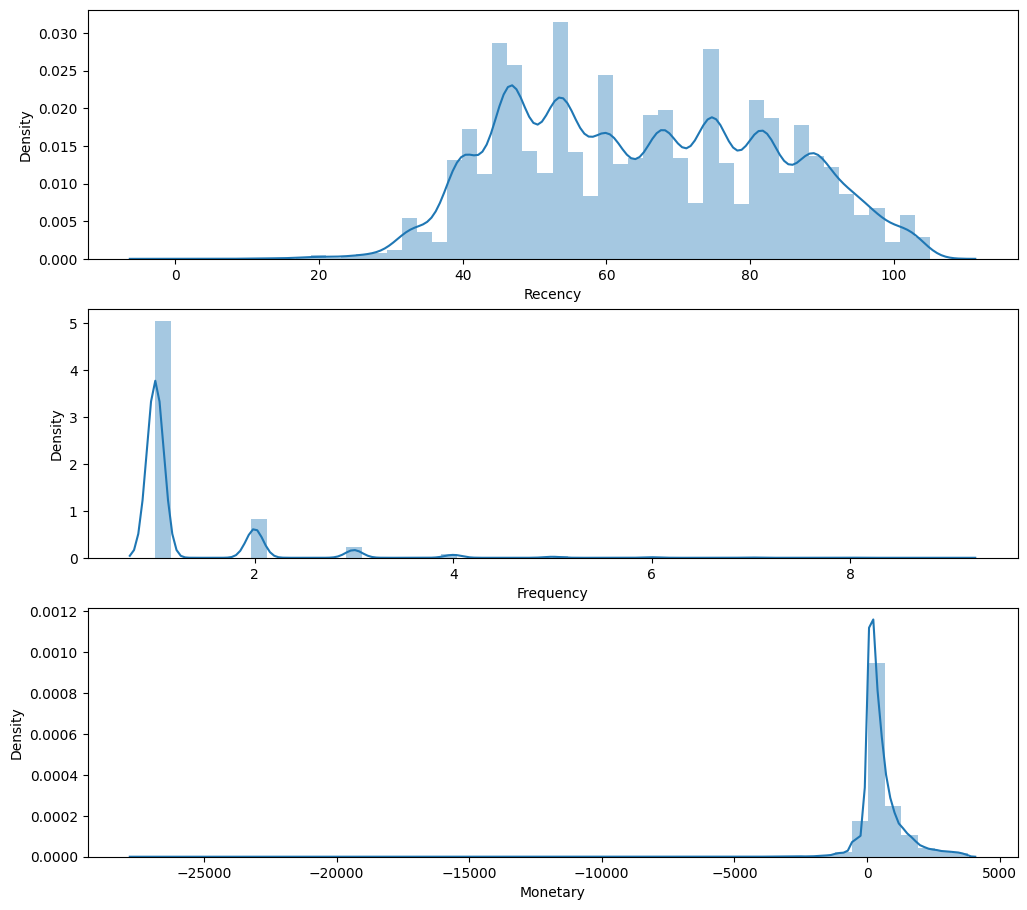

In [212]:
# Plot RFM distributions
plt.figure(figsize=(12,11))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(RFM['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(RFM['Frequency'][RFM['Frequency'] < RFM['Frequency'].quantile(0.999)])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(RFM['Monetary'][RFM['Monetary'] < RFM['Monetary'].quantile(0.97)])
# Show the plot
plt.show()

In [213]:
# --Calculate R and F groups--
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 4)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(RFM['Recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(RFM['Frequency'], q=20, labels=f_labels, duplicates='drop')
# Create new columns R and F 
RFM = RFM.assign(R = r_groups.values, F = f_groups.values)
RFM.head()

,Recency,Frequency,Monetary,R,F
phone,,,,,
55574952-54495149535073,0,1,-454.75,4,1
55575449-57535254515373,6,1,524.24,4,1
55574857-56495152564976,10,5,5281.98,4,3
55575450-50565257574878,10,1,108.35,4,1
55574952-48524855555674,10,5,8713.21,4,3


In [214]:
# Create labels for MonetaryValue
m_labels = range(1, 5)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(RFM['Monetary'], q=4, labels=m_labels)
# Create new column M
RFM = RFM.assign(M = m_groups.values)

In [215]:
RFM

,Recency,Frequency,Monetary,R,F,M
phone,,,,,,
55574952-54495149535073,0,1,-454.75,4,1,1
55575449-57535254515373,6,1,524.24,4,1,3
55574857-56495152564976,10,5,5281.98,4,3,4
55575450-50565257574878,10,1,108.35,4,1,1
55574952-48524855555674,10,5,8713.21,4,3,4
...,...,...,...,...,...,...
55575053-52535554564978,104,1,223.11,1,1,2
55574852-49485452495570,104,1,135.25,1,1,2
55575455-48545456485675,104,1,800.00,1,1,3


In [216]:
%%time
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): 
    return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))

RFM['RFM_Segment_Concat'] = RFM.apply(join_rfm, axis=1)
rfm = RFM
rfm.head()

CPU times: user 239 ms, sys: 5.17 ms, total: 244 ms
Wall time: 244 ms


,Recency,Frequency,Monetary,R,F,M,RFM_Segment_Concat
phone,,,,,,,
55574952-54495149535073,0,1,-454.75,4,1,1,411
55575449-57535254515373,6,1,524.24,4,1,3,413
55574857-56495152564976,10,5,5281.98,4,3,4,434
55575450-50565257574878,10,1,108.35,4,1,1,411
55574952-48524855555674,10,5,8713.21,4,3,4,434


In [217]:
# Count num of unique segments
rfm_count_unique = rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print('Number of unique segmens:', rfm_count_unique.sum())

Number of unique segmens: 48


<h3>Summing the score</h3>

In [218]:
# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'].head())

phone
55574952-54495149535073     6
55575449-57535254515373     8
55574857-56495152564976    11
55575450-50565257574878     6
55574952-48524855555674    11
Name: RFM_Score, dtype: int64


In [219]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Sleeping' # Primising
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
phone,,,,,,,,,
55574952-54495149535073,0,1,-454.75,4,1,1,411,6,Potential
55575449-57535254515373,6,1,524.24,4,1,3,413,8,Champions
55574857-56495152564976,10,5,5281.98,4,3,4,434,11,Can't Loose Them
55575450-50565257574878,10,1,108.35,4,1,1,411,6,Potential
55574952-48524855555674,10,5,8713.21,4,3,4,434,11,Can't Loose Them


<h3>RFM results</h3>

In [220]:
import squarify

In [221]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg.loc[["Can't Loose Them", "Champions", "Loyal", "Potential", "Sleeping", "Require Activation"]])

                   Recency Frequency Monetary       
                      mean      mean     mean  count
RFM_Level                                           
Can't Loose Them      44.7       2.6   2101.6   4146
Champions             50.3       1.4   1247.0   5376
Loyal                 57.8       1.3    941.0   8066
Potential             64.4       1.1    612.5  10996
Sleeping              72.5       1.1    191.9   8843
Require Activation    89.6       1.0    -73.1   2884


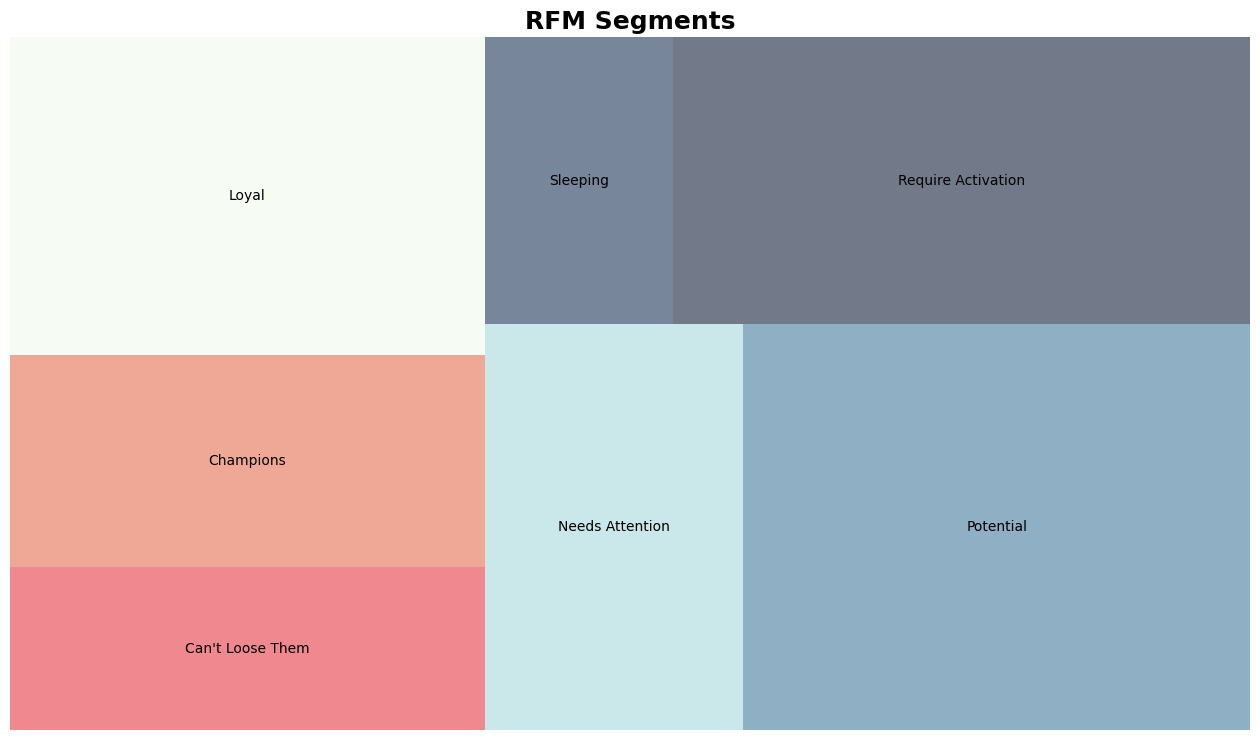

In [222]:
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Sleeping', 
                     'Require Activation'],
              color=['#e63946',
                     '#e76f51',
                     '#f1faee',
                     '#a8dadc',
                     '#457b9d',
                     '#1d3557',
                     '#14213d'],
              alpha=.6,)
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

<h3>Save RFM</h3>

In [223]:
from pathlib import Path

In [224]:
Path("../data/sas/rfm").mkdir(parents=True, exist_ok=True)

In [225]:
rfm.to_parquet('../data/sas/mart/rfm.parquet')